## <center> Import Libs

In [72]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (13, 8)
plt.rcParams["font.size"] = 18

import seaborn as sns
# Customizing seaborn color palette
sns.light_palette("seagreen", as_cmap=True)
sns.set(style="darkgrid")

import plotly.express as px
import plotly.figure_factory as ff

import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "notebook_connected"

from statsmodels.graphics.tsaplots import plot_pacf

from autots import AutoTS

import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
import string

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report

from pycaret.classification import *

import warnings 
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrejbaranov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## <center> Import Data

In [73]:
data = pd.read_csv('data/hate_speech.csv')
data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [74]:
hate_speech_labels = {
    0: "Hate Speech", 
    1: "Offensive Language", 
    2: "No Hate and Offensive"
}

## <center> Data Info

In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [76]:
data.describe()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000
max,25296.000000,9.000000,7.000000,9.000000,9.000000,2.000000


## <center> Null data / Duplicates

In [77]:
data.isnull().sum()

Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

In [78]:
print(f"Duplicated data: {data.duplicated().sum()}")

Duplicated data: 0


In [79]:
data.drop_duplicates(inplace=True)
print(f"Duplicated data after dropping: {data.duplicated().sum()}")

Duplicated data after dropping: 0


## <center> Wordcloud

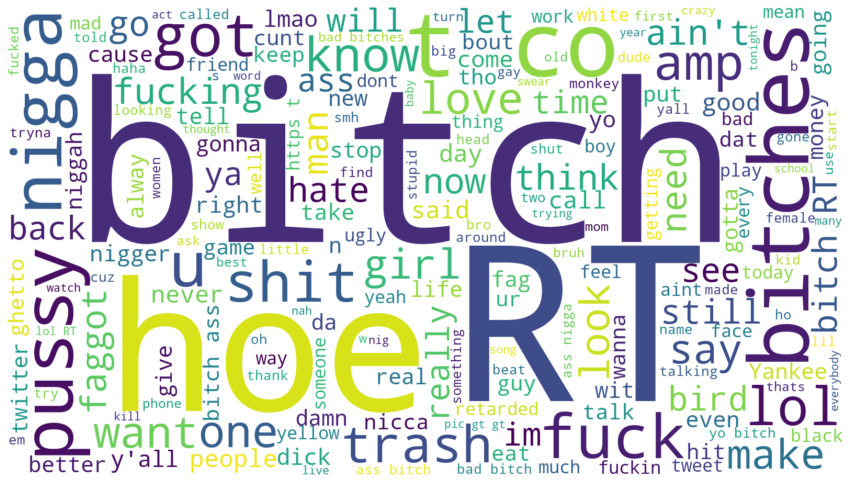

In [80]:
text = " ".join(i for i in data.tweet)
stopwords_wc = set(STOPWORDS)

wordcloud = WordCloud(
    stopwords=stopwords_wc, 
    background_color="white",
    width=1600,
    height=900
).generate(text)

plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## <center> Data Validation

In [81]:
data = data[['tweet', 'hate_speech']]
data.head()

,tweet,hate_speech
0,!!! RT @mayasolovely: As a woman you shouldn't...,0
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,0
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,0
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,0
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,0


In [82]:
stemmer = nltk.SnowballStemmer("english")
stopword = set(stopwords.words('english'))

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text

data["tweet"] = data["tweet"].apply(clean)

## <center> Labels Ratio

In [83]:
labels_value_counts = data['hate_speech'].map(hate_speech_labels).value_counts()

labels_names = labels_value_counts.index
labels_values = labels_value_counts.values

px.pie(
    names=labels_names,
    values=labels_values,
    hole=0.4,
    title="Hate Speech Ratio"
)

## <center> Defining X and y

In [84]:
X = data['tweet']
y = data['hate_speech']

## <center> Applying Count Vectorizer

In [85]:
cv = CountVectorizer()

X = cv.fit_transform(X)

## <center> Dividing Into Train / Test data

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=1)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (22304, 25693)
X_test shape: (2479, 25693)
y_train shape: (22304,)
y_test shape: (2479,)


## <center> Modeling Part

In [87]:
train_data = pd.DataFrame(X_train)
train_data['hate_speech'] = y_train

clf = setup(data, target = "hate_speech", session_id = 1, preprocess=False)
compare_models()

,Description,Value
0,Session id,1
1,Target,hate_speech
2,Target type,Multiclass
3,Original data shape,"(24783, 2)"
4,Transformed data shape,"(24783, 2)"
5,Transformed train set shape,"(17348, 2)"
6,Transformed test set shape,"(7435, 2)"
7,Categorical features,1


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7985,0.0000,0.7985,0.6377,0.7091,0.0000,0.0000,0.1120
dummy,Dummy Classifier,0.7985,0.0000,0.7985,0.6377,0.7091,0.0000,0.0000,0.0110


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=1, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## <center> Model Creation, Tuning

In [88]:
model = create_model('lightgbm')
model

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7988,0.0000,0.7988,0.6382,0.7095,0.0000,0.0000
1,0.7988,0.0000,0.7988,0.6382,0.7095,0.0000,0.0000
2,0.7988,0.0000,0.7988,0.6382,0.7095,0.0000,0.0000
3,0.7983,0.0000,0.7983,0.6372,0.7087,0.0000,0.0000
4,0.7983,0.0000,0.7983,0.6372,0.7087,0.0000,0.0000
5,0.7983,0.0000,0.7983,0.6372,0.7087,0.0000,0.0000
6,0.7983,0.0000,0.7983,0.6372,0.7087,0.0000,0.0000
7,0.7983,0.0000,0.7983,0.6372,0.7087,0.0000,0.0000
8,0.7987,0.0000,0.7987,0.6380,0.7094,0.0000,0.0000


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=1, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [89]:
params = {
    'learning_rate': [0.001, 0.01, 0.1, 1],
    'n_estimators': [10, 100, 200, 500, 1000],
    'max_depth': [10, 50, 100, -1]
}

tuned = tune_model(model, custom_grid = params)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7988,0.0000,0.7988,0.6382,0.7095,0.0000,0.0000
1,0.7988,0.0000,0.7988,0.6382,0.7095,0.0000,0.0000
2,0.7988,0.0000,0.7988,0.6382,0.7095,0.0000,0.0000
3,0.7983,0.0000,0.7983,0.6372,0.7087,0.0000,0.0000
4,0.7983,0.0000,0.7983,0.6372,0.7087,0.0000,0.0000
5,0.7983,0.0000,0.7983,0.6372,0.7087,0.0000,0.0000
6,0.7983,0.0000,0.7983,0.6372,0.7087,0.0000,0.0000
7,0.7983,0.0000,0.7983,0.6372,0.7087,0.0000,0.0000
8,0.7987,0.0000,0.7987,0.6380,0.7094,0.0000,0.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
